## Class Activation Map

Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2016.

참고: http://jsideas.net/python/2018/01/04/class_activation_map.html

- 원래는 object detection 을 bounding box label 없이 하기 위해서 제안된 방법인 듯
- Visualization 방법으로 더 많이 알려짐. CAM 이라고 한다.

## Method

http://jsideas.net/python/2018/01/04/class_activation_map.html

- GAP 를 쓰는 경우를 생각해보자. GAP 를 씌운 후 fc 레이어가 붙어서 logit 이 나온다. 
- 여기서 특정 클래스에 대해 생각하면, fc 레이어는 각 피처맵의 GAP 값들에 대한 weighted average 가 된다.
- 이 상태에서 GAP 를 벗기면, 각 피처맵에 대한 weight 가 된다는 것.
- 따라서 이 weight 에 따라서 피처맵의 activation 값들을 더해주면 이 클래스에 대한 activation 을 확인할 수 있다!

### Why only for GAP?

왜 GAP (global average pooling) 이어야 할까?

- 위 링크에서는 GAP 가 오브젝트의 위치를 보존하기 때문이라고 하는데. 잘 이해 안 됨;
- 상관없을 것 같은데...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import cv2
import seaborn as sns
from utils import *
from cluttered_mnist import ClutteredMNISTDataset
from models import ConvGAP

In [2]:
from glob import glob
import os

In [3]:
train_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=True, transform=transforms.ToTensor())
valid_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=False, transform=transforms.ToTensor())

processed dataset already exists; load it
processed dataset already exists; load it


In [4]:
len(train_dataset), len(valid_dataset)

(90000, 10000)

In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model = ConvGAP()
model.cuda()

ConvGAP (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear): Linear (128 -> 10)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
n_epochs = 5

total_loss = AverageMeter()
total_acc = AverageMeter()

for epoch in range(n_epochs):
    total_loss.reset()
    total_acc.reset()
    for X, y in train_loader:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        pred = y_.data.max(1)[1]
        
        acc = float(pred.eq(y.data).sum()) / train_loader.batch_size
        total_loss.update(loss.data[0])
        total_acc.update(acc)
    
    print("[TRAIN EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))
    
    total_loss.reset()
    total_acc.reset()
    for X, y in valid_loader:
        X = Variable(X).cuda()
        y = Variable(y).cuda()
        
        y_ = model(X)
        loss = criterion(y_, y)
        pred = y_.data.max(1)[1]
        acc = float(pred.eq(y.data).sum()) / valid_loader.batch_size
        total_loss.update(loss.data[0])
        total_acc.update(acc)
    
    print("[VALID EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))

[TRAIN EPOCH  1]	LOSS 1.2276	ACC 60.60%
[VALID EPOCH  1]	LOSS 0.2676	ACC 90.88%
[TRAIN EPOCH  2]	LOSS 0.2057	ACC 93.62%
[VALID EPOCH  2]	LOSS 0.1490	ACC 94.53%
[TRAIN EPOCH  3]	LOSS 0.1358	ACC 95.74%
[VALID EPOCH  3]	LOSS 0.1220	ACC 95.28%
[TRAIN EPOCH  4]	LOSS 0.1048	ACC 96.60%
[VALID EPOCH  4]	LOSS 0.0961	ACC 95.90%
[TRAIN EPOCH  5]	LOSS 0.0864	ACC 97.20%
[VALID EPOCH  5]	LOSS 0.1068	ACC 95.65%


## CAM

In [11]:
list(model.named_modules())

[('', ConvGAP (
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (linear): Linear (128 -> 10)
  )),
 ('conv1', Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('conv2', Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('conv3', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('linear', Linear (128 -> 10))]

In [16]:
mod = list(model.modules())[-1]

In [11]:
# last fc layer weights
named_params = list(model.named_parameters())

last_linear_weight = named_params[-2]
last_linear_bias = named_params[-1]

last_linear_weight[0], last_linear_bias[0]

('linear.weight', 'linear.bias')

In [12]:
last_linear_weight[1].size(), last_linear_bias[1].size()

(torch.Size([10, 64]), torch.Size([10]))

In [13]:
def get_activated_map(model, X):
    '''
    input X 에 대한 activation map
    '''
    
    if X.dim() == 3:
        X.unsqueeze_(0)
    
    X = Variable(X).cuda()
    
    y_, last_featuremaps = model(X)
    pred = y_.data.max(1)[1] # [B]
    pred = pred[0] # []
    
    weights = last_linear_weight[1][pred].data.cpu() # [C]
    # bias 는 어차피 class 에 대해서 동일하므로 필요 없을듯
    # bias = last_linear_bias[1][pred].data.cpu() # []
    
#     print last_featuremaps.size()
    last_featuremaps = last_featuremaps.data.cpu()
    last_featuremaps.squeeze_() # [1, C, K, K] => [C, K, K]
    weights.unsqueeze_(1).unsqueeze_(1) # [C] => [C, 1, 1]
    activated = weights * last_featuremaps # [C, 1, 1] * [C, K, K] => [C, K, K]
    activated = activated.sum(0) # [K, K]
    
    return activated, pred

In [14]:
def normalize(v):
    return (v - v.min()) / (v.max() - v.min())

In [15]:
def cam(idx, wrong_only=False):
    X, y = valid_dataset[idx]
    activ_map, pred = get_activated_map(model, X)
    if wrong_only and y == pred:
        return
    activ_map = activ_map.numpy()
    norm_activ_map = normalize(activ_map)
    shape = [100, 100]
    activ_map = cv2.resize(norm_activ_map, tuple(shape), interpolation=cv2.INTER_LINEAR)
    
    prt = X.numpy().squeeze().transpose([1, 2, 0]) # CHW => HWC

    activ_map_int = (activ_map*255).astype(np.uint8)
    heatmap = cv2.cvtColor(cv2.applyColorMap(activ_map_int, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    heatmap_float = heatmap.astype(np.float32)/255.
    prt_int = (prt*255).astype(np.uint8)
    result = heatmap_float * 0.3 + prt * 0.5
    
#     concat = np.concatenate([prt_int, activ_map_int, heatmap], axis=1)
    print "Pred: {} / Label: {}".format(pred, y)
    if pred != y:
        print "!!!!! Wrong !!!!!"
#     plt.imshow(result)

    fig = plt.figure(figsize=(12, 6))
    plt.jet()
    
    # org
    plt.subplot(1, 4, 1)
    plt.imshow(prt, vmin=0., vmax=1., cmap='Greys_r')
    plt.axis('off')

    # hot
    plt.subplot(1, 4, 2)
#     plt.hot()
    plt.imshow(activ_map, vmin=0., vmax=1., cmap=plt.cm.hot)
    plt.axis('off')
    
    # jet + colorbar
    plt.subplot(1, 4, 3)
#     sns.heatmap(activ_map, vmin=0., vmax=1.)
    heatmap_im = plt.imshow(heatmap)
    plt.colorbar(heatmap_im, fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # overlay
    plt.subplot(1, 4, 4)
    plt.imshow(result)
    plt.axis('off')
    
    plt.show()
    
#     sns.heatmap(activ_map, vmin=0., vmax=1.)
#     plt.show()

Pred: 1 / Label: 1


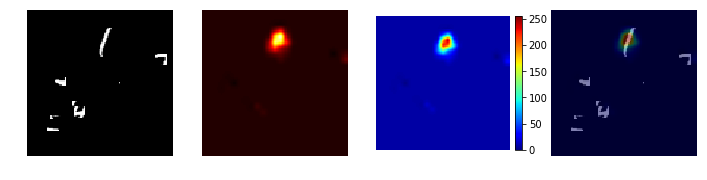

Pred: 3 / Label: 3


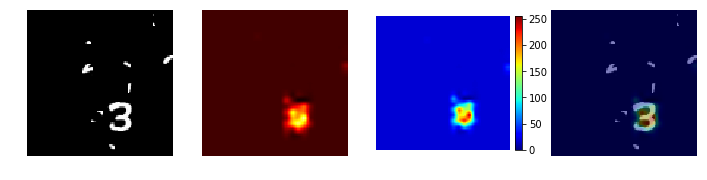

Pred: 8 / Label: 8


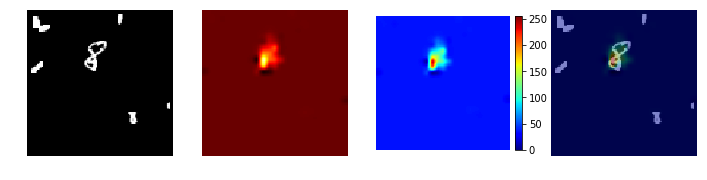

Pred: 5 / Label: 5


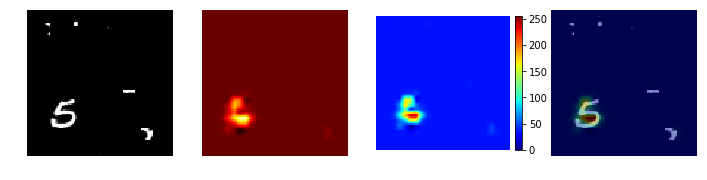

Pred: 0 / Label: 0


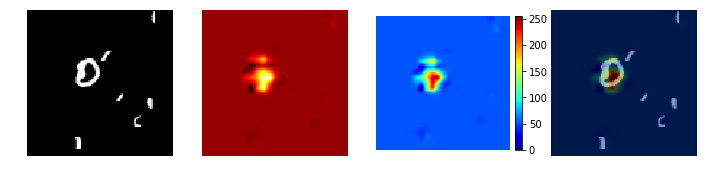

Pred: 9 / Label: 9


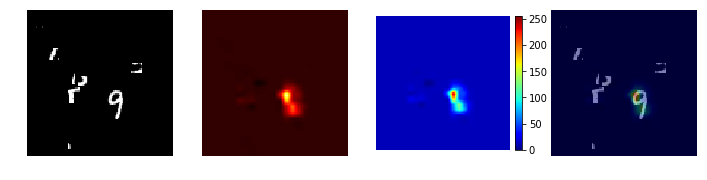

Pred: 5 / Label: 5


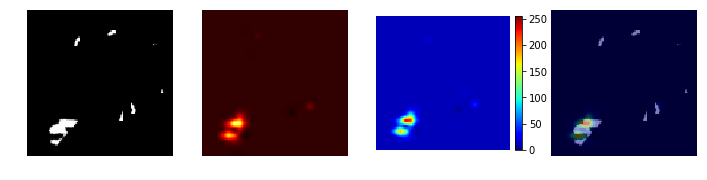

Pred: 3 / Label: 3


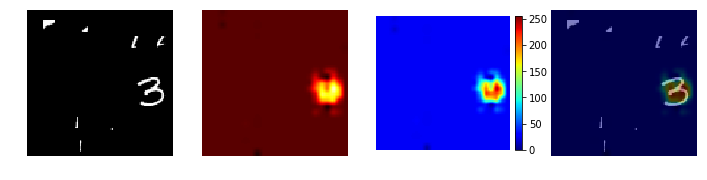

Pred: 1 / Label: 1


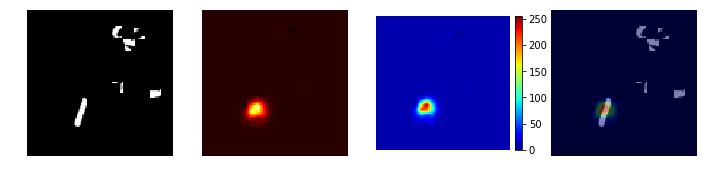

Pred: 1 / Label: 1


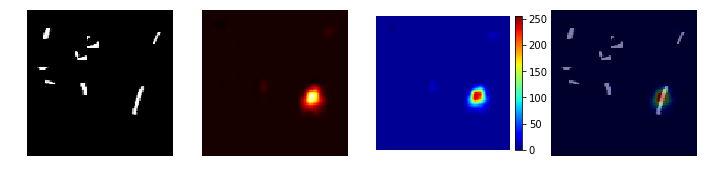

In [16]:
for i in range(0, 10):
    cam(i, False)